# Machine Learning Lab — Association Rules 
## Objectives
By the end of this lab, students will be able to:

-  Convert **invoice-level purchases** into **transaction baskets**
-  Discover **frequent itemsets** using the **Apriori** algorithm
-  Generate **association rules** (*A ⇒ B*) and interpret them using:
  -  **Support** (how common)
  -  **Confidence** (how reliable)
  -  **Lift** (how meaningful vs chance)
-  Translate patterns into **business insights**:
  -  Bundling
  -  Cross-selling
  -  Recommendations

---

##  Lab Roadmap
1.  Load the dataset  
2.  Clean and pre-process transactions 
3.  Build the basket matrix (True/False)  
4.  Explore transactions with simple graphs  
5.  Frequent itemsets (Apriori)  
6.  Association rules (Lift)  
7.  Professor-style visualization (support vs confidence; dot size ∝ lift)  
8.  Business interpretation + discussion  
9.  Learning outcomes


##  Concepts & Definitions

### Transactional Data
A **transaction** is one invoice (one shopping basket). Each transaction contains a set of products purchased together.

### Association Rule
An association rule has the form:

> **A ⇒ B**  
> If a customer buys **A**, they are likely to buy **B**.

### Key Metrics
- **Support**: how frequently an itemset appears in the dataset (popularity).
- **Confidence**: how often **B** occurs when **A** occurs (rule reliability).
- **Lift**: how much stronger the rule is compared to chance.  
   **Lift > 1** indicates a meaningful association.


## Step 0 — Imports
We use **pandas** for data handling, **mlxtend** for Apriori + rules, and **matplotlib** for plots.


In [23]:
# If needed (run once):
# !pip install mlxtend openpyxl

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mlxtend.frequent_patterns import apriori, association_rules



## Step 1 — Load the Dataset
We use an online retail dataset (France). Each row is one item purchased on an invoice.


In [25]:
df = pd.read_excel("Online-Retail-France.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583.0
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,12583.0
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583.0
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,2010-12-01 08:45:00,0.85,12583.0
4,536370,21883,STARS GIFT TAPE,24,2010-12-01 08:45:00,0.65,12583.0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
11,536370,22631,CIRCUS PARADE LUNCH BOX,24,2010-12-01 08:45:00,1.95,12583.0
12,536370,22661,CHARLOTTE BAG DOLLY GIRL DESIGN,20,2010-12-01 08:45:00,0.85,12583.0
23,536852,22661,CHARLOTTE BAG DOLLY GIRL DESIGN,10,2010-12-03 09:51:00,0.85,12686.0
47,537065,84678,CLASSICAL ROSE SMALL VASE,6,2010-12-05 11:57:00,2.55,12567.0
71,537065,21555,CERAMIC STRAWBERRY TRINKET TRAY,6,2010-12-05 11:57:00,2.55,12567.0
...,...,...,...,...,...,...,...
8549,581587,22367,CHILDRENS APRON SPACEBOY DESIGN,8,2011-12-09 12:50:00,1.95,12680.0
8551,581587,23256,CHILDRENS CUTLERY SPACEBOY,4,2011-12-09 12:50:00,4.15,12680.0
8553,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0
8554,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
19,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.0,12583.0
26,536852,POST,POSTAGE,1,2010-12-03 09:51:00,18.0,12686.0
42,536974,POST,POSTAGE,2,2010-12-03 13:59:00,18.0,12682.0
105,537065,POST,POSTAGE,9,2010-12-05 11:57:00,18.0,12567.0
146,537463,POST,POSTAGE,4,2010-12-07 10:08:00,18.0,12681.0
...,...,...,...,...,...,...,...
2433,552315,POST,POSTAGE,6,2011-05-08 16:10:00,18.0,12700.0
2448,C552317,POST,POSTAGE,-2,2011-05-08 16:12:00,18.0,12700.0
2465,552325,POST,POSTAGE,2,2011-05-09 09:47:00,18.0,12490.0
2476,552464,POST,POSTAGE,1,2011-05-09 15:12:00,18.0,12726.0


##  Step 2 — Data Cleaning and Pre-processing

We remove:
-  Canceled invoices (InvoiceNo starts with 'C')
-  Missing invoice/product descriptions
-  Non-positive quantities

### Why we remove **POSTAGE**
In this dataset, **POSTAGE** is extremely frequent, but it is **not a real product** customers choose.  
It is a **shipping/handling charge**, so it does **not** provide actionable business insight for:
- bundling
- cross-selling
- recommendations

If we keep POSTAGE, it dominates the results (high support), and many “strong rules” become trivial and not business-meaningful.


In [36]:
# Remove canceled invoices
#~ means “NOT” ----> Keep rows where the invoice number does not start with C

# Remove missing descriptions


# Keep only positive quantities


# Exclude POSTAGE (business-motivated pre-processing)





,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583.0
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,12583.0
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583.0
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,2010-12-01 08:45:00,0.85,12583.0
4,536370,21883,STARS GIFT TAPE,24,2010-12-01 08:45:00,0.65,12583.0


---
## Step 2.1 — Quick Dataset Snapshot
A fast overview helps understand the scale of the data.


In [38]:
print("Rows:", len(df))
print("Unique invoices (transactions):", df["InvoiceNo"].nunique())
print("Unique products:", df["Description"].nunique())


Rows: 8107
Unique invoices (transactions): 387
Unique products: 1563


## Step 2.2 — Transaction Size Distribution

This histogram shows how many **distinct products** customers purchase per invoice.

- **X-axis**: Number of distinct products  
- **Y-axis**: Number of invoices  

It helps us understand **typical basket sizes**, identify **unusually large transactions**, and assess whether the data is dominated by small or large baskets.

**Key insight:**  
Most transactions contain only a few products, while a small number of invoices have many items, producing a right-skewed distribution.


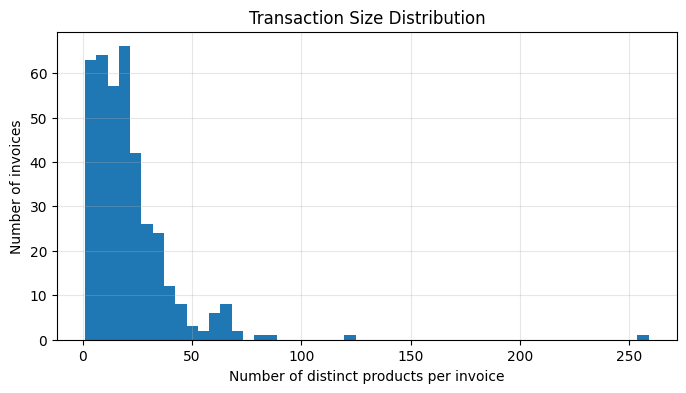

In [47]:
# Number of distinct products per invoice (basket size)
basket_sizes = df.groupby("InvoiceNo")["Description"].nunique()

# Plot distribution of basket sizes
plt.figure(figsize=(8, 4))
plt.hist(basket_sizes, bins=50)

plt.title("Transaction Size Distribution")
plt.xlabel("Number of distinct products per invoice")
plt.ylabel("Number of invoices")

plt.grid(True, alpha=0.3)
plt.show()


## Step 3 — Transactions → Basket Matrix
We convert data into a basket matrix:

- Rows = invoices
- Columns = products
- Values = True/False (bought / not bought)


Description,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TRELLIS COAT RACK,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,...,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,YELLOW SHARK HELICOPTER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536370,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536852,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536974,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
537065,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
537463,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [49]:
basket.columns

Index([' 50'S CHRISTMAS GIFT BAG LARGE', ' DOLLY GIRL BEAKER',
       ' I LOVE LONDON MINI BACKPACK', ' NINE DRAWER OFFICE TIDY',
       ' SET 2 TEA TOWELS I LOVE LONDON ', ' SPACEBOY BABY GIFT SET',
       ' TRELLIS COAT RACK', '10 COLOUR SPACEBOY PEN',
       '12 COLOURED PARTY BALLOONS', '12 EGG HOUSE PAINTED WOOD',
       ...
       'WRAP VINTAGE PETALS  DESIGN', 'YELLOW COAT RACK PARIS FASHION',
       'YELLOW GIANT GARDEN THERMOMETER', 'YELLOW SHARK HELICOPTER',
       'ZINC  STAR T-LIGHT HOLDER ', 'ZINC FOLKART SLEIGH BELLS',
       'ZINC HERB GARDEN CONTAINER', 'ZINC METAL HEART DECORATION',
       'ZINC T-LIGHT HOLDER STAR LARGE', 'ZINC T-LIGHT HOLDER STARS SMALL'],
      dtype='str', name='Description', length=1563)

In [53]:
list(basket.columns)

[" 50'S CHRISTMAS GIFT BAG LARGE",
 ' DOLLY GIRL BEAKER',
 ' I LOVE LONDON MINI BACKPACK',
 ' NINE DRAWER OFFICE TIDY',
 ' SET 2 TEA TOWELS I LOVE LONDON ',
 ' SPACEBOY BABY GIFT SET',
 ' TRELLIS COAT RACK',
 '10 COLOUR SPACEBOY PEN',
 '12 COLOURED PARTY BALLOONS',
 '12 EGG HOUSE PAINTED WOOD',
 '12 MESSAGE CARDS WITH ENVELOPES',
 '12 PENCIL SMALL TUBE WOODLAND',
 '12 PENCILS SMALL TUBE RED RETROSPOT',
 '12 PENCILS SMALL TUBE SKULL',
 '12 PENCILS TALL TUBE POSY',
 '12 PENCILS TALL TUBE RED RETROSPOT',
 '12 PENCILS TALL TUBE WOODLAND',
 '15CM CHRISTMAS GLASS BALL 20 LIGHTS',
 '16 PIECE CUTLERY SET PANTRY DESIGN',
 '18PC WOODEN CUTLERY SET DISPOSABLE',
 '20 DOLLY PEGS RETROSPOT',
 '200 RED + WHITE BENDY STRAWS',
 '3 HOOK HANGER MAGIC GARDEN',
 '3 PIECE SPACEBOY COOKIE CUTTER SET',
 "3 RAFFIA RIBBONS 50'S CHRISTMAS ",
 '3 STRIPEY MICE FELTCRAFT',
 '3 TIER CAKE TIN RED AND CREAM',
 '3 TRADITIONAl BISCUIT CUTTERS  SET',
 '36 DOILIES DOLLY GIRL',
 '36 DOILIES VINTAGE CHRISTMAS',
 '36 FOIL HE

## Step 3.1 — Most Popular Products
We compute product **support** (how often each product appears across transactions).


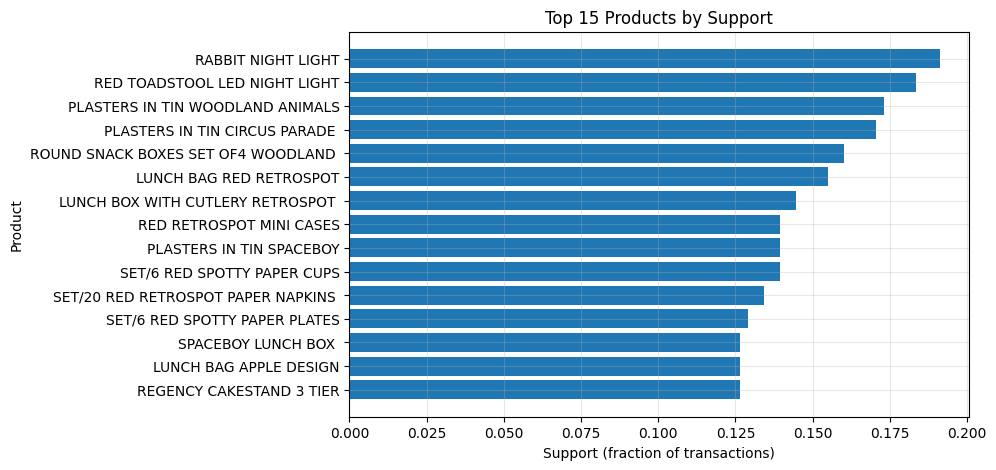

Description
REGENCY CAKESTAND 3 TIER               0.126615
LUNCH BAG APPLE DESIGN                 0.126615
SPACEBOY LUNCH BOX                     0.126615
SET/6 RED SPOTTY PAPER PLATES          0.129199
SET/20 RED RETROSPOT PAPER NAPKINS     0.134367
SET/6 RED SPOTTY PAPER CUPS            0.139535
PLASTERS IN TIN SPACEBOY               0.139535
RED RETROSPOT MINI CASES               0.139535
LUNCH BOX WITH CUTLERY RETROSPOT       0.144703
LUNCH BAG RED RETROSPOT                0.155039
ROUND SNACK BOXES SET OF4 WOODLAND     0.160207
PLASTERS IN TIN CIRCUS PARADE          0.170543
PLASTERS IN TIN WOODLAND ANIMALS       0.173127
RED TOADSTOOL LED NIGHT LIGHT          0.183463
RABBIT NIGHT LIGHT                     0.191214
dtype: float64

In [59]:
item_support = basket.mean().sort_values(ascending=False)

top_n = 15
top_items = item_support.head(top_n)[::-1]  # reverse for a clean horizontal bar plot

plt.figure(figsize=(8,5))
plt.barh(top_items.index, top_items.values)
plt.title(f"Top {top_n} Products by Support")
plt.xlabel("Support (fraction of transactions)")
plt.ylabel("Product")
plt.grid(True, alpha=0.3)
plt.show()

top_items


## Step 4 — Frequent Itemsets (Apriori)

Apriori finds **products that frequently appear together** in the same invoice.

- An **itemset** is a group of products (1 item, 2 items, or more)
- **Support** shows how often an itemset appears in the data  
  (e.g., support = 0.02 → appears in 2% of invoices)

This step is the **foundation for association rules** like  
“if a customer buys A, they also buy B”.


,support,itemsets,length
168,0.191214,frozenset({RABBIT NIGHT LIGHT}),1
191,0.183463,frozenset({RED TOADSTOOL LED NIGHT LIGHT}),1
161,0.173127,frozenset({PLASTERS IN TIN WOODLAND ANIMALS}),1
156,0.170543,frozenset({PLASTERS IN TIN CIRCUS PARADE }),1
207,0.160207,frozenset({ROUND SNACK BOXES SET OF4 WOODLAND }),1
114,0.155039,frozenset({LUNCH BAG RED RETROSPOT}),1
121,0.144703,frozenset({LUNCH BOX WITH CUTLERY RETROSPOT }),1
183,0.139535,frozenset({RED RETROSPOT MINI CASES}),1
242,0.139535,frozenset({SET/6 RED SPOTTY PAPER CUPS}),1
158,0.139535,frozenset({PLASTERS IN TIN SPACEBOY}),1


## Itemset Size vs Support

This plot shows how **support changes with itemset size**.

- **Itemset size (length)**: number of products in an itemset  
- **Support**: how frequently that itemset appears in invoices  

As itemset size increases, support usually **decreases**, because it is less likely for many products to be purchased together.

This helps us understand:
- How quickly frequency drops as combinations get larger
- A reasonable cutoff for itemset size in market basket analysis


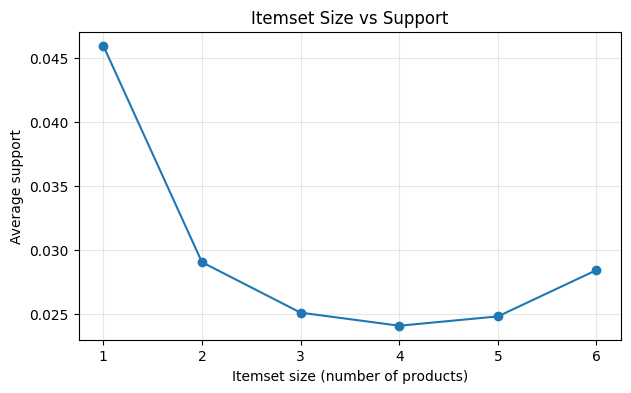

In [64]:
# Average support for each itemset size
size_support = (
    frequent_itemsets
    .groupby("length")["support"]
    .mean()
)

plt.figure(figsize=(7,4))
plt.plot(size_support.index, size_support.values, marker='o')

plt.xlabel("Itemset size (number of products)")
plt.ylabel("Average support")
plt.title("Itemset Size vs Support")
plt.grid(True, alpha=0.3)
plt.show()


---
## 🔗 Step 5 —  Association Rules

Association rules identify **products that are frequently bought together**.

They follow the pattern:

**If A is purchased → B is likely purchased**

Where:
- **Antecedent (A)** = items already bought  
- **Consequent (B)** = items likely to be bought next  

### Key metrics
- **Support**: how often A and B appear together  
- **Confidence**: probability of B given A  
- **Lift**: strength of the relationship  
  - lift > 1 → meaningful association


In [66]:
# Generate association rules using lift


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,antecedents_str,consequents_str
4254,"frozenset({SET/6 RED SPOTTY PAPER CUPS, ALARM ...","frozenset({ALARM CLOCK BAKELIKE GREEN, SET/6 R...",0.025840,0.020672,0.020672,0.800000,38.700000,1.0,0.020138,4.896641,1.000000,0.800000,0.795778,0.900000,"SET/6 RED SPOTTY PAPER CUPS, ALARM CLOCK BAKEL...","ALARM CLOCK BAKELIKE GREEN, SET/6 RED SPOTTY P..."
4255,"frozenset({ALARM CLOCK BAKELIKE GREEN, SET/6 R...","frozenset({SET/6 RED SPOTTY PAPER CUPS, ALARM ...",0.020672,0.025840,0.020672,1.000000,38.700000,1.0,0.020138,inf,0.994723,0.800000,1.000000,0.900000,"ALARM CLOCK BAKELIKE GREEN, SET/6 RED SPOTTY P...","SET/6 RED SPOTTY PAPER CUPS, ALARM CLOCK BAKEL..."
4252,"frozenset({SET/6 RED SPOTTY PAPER CUPS, ALARM ...","frozenset({ALARM CLOCK BAKELIKE PINK, SET/6 RE...",0.023256,0.023256,0.020672,0.888889,38.222222,1.0,0.020131,8.790698,0.997024,0.800000,0.886243,0.888889,"SET/6 RED SPOTTY PAPER CUPS, ALARM CLOCK BAKEL...","ALARM CLOCK BAKELIKE PINK, SET/6 RED SPOTTY PA..."
4257,"frozenset({ALARM CLOCK BAKELIKE PINK, SET/6 RE...","frozenset({SET/6 RED SPOTTY PAPER CUPS, ALARM ...",0.023256,0.023256,0.020672,0.888889,38.222222,1.0,0.020131,8.790698,0.997024,0.800000,0.886243,0.888889,"ALARM CLOCK BAKELIKE PINK, SET/6 RED SPOTTY PA...","SET/6 RED SPOTTY PAPER CUPS, ALARM CLOCK BAKEL..."
3857,frozenset({RECYCLED ACAPULCO MAT LAVENDER}),"frozenset({RECYCLED ACAPULCO MAT TURQUOISE, RE...",0.025840,0.023256,0.020672,0.800000,34.400000,1.0,0.020071,4.883721,0.996684,0.727273,0.795238,0.844444,RECYCLED ACAPULCO MAT LAVENDER,"RECYCLED ACAPULCO MAT TURQUOISE, RECYCLED ACAP..."
3852,"frozenset({RECYCLED ACAPULCO MAT TURQUOISE, RE...",frozenset({RECYCLED ACAPULCO MAT LAVENDER}),0.023256,0.025840,0.020672,0.888889,34.400000,1.0,0.020071,8.767442,0.994048,0.727273,0.885942,0.844444,"RECYCLED ACAPULCO MAT TURQUOISE, RECYCLED ACAP...",RECYCLED ACAPULCO MAT LAVENDER
4659,"frozenset({DOLLY GIRL CHILDRENS CUP, SPACEBOY ...","frozenset({DOLLY GIRL CHILDRENS BOWL, SPACEBOY...",0.033592,0.028424,0.028424,0.846154,29.769231,1.0,0.027469,6.315245,1.000000,0.846154,0.841653,0.923077,"DOLLY GIRL CHILDRENS CUP, SPACEBOY CHILDRENS BOWL","DOLLY GIRL CHILDRENS BOWL, SPACEBOY CHILDRENS CUP"
4662,"frozenset({DOLLY GIRL CHILDRENS BOWL, SPACEBOY...","frozenset({DOLLY GIRL CHILDRENS CUP, SPACEBOY ...",0.028424,0.033592,0.028424,1.000000,29.769231,1.0,0.027469,inf,0.994681,0.846154,1.000000,0.923077,"DOLLY GIRL CHILDRENS BOWL, SPACEBOY CHILDRENS CUP","DOLLY GIRL CHILDRENS CUP, SPACEBOY CHILDRENS BOWL"
1211,frozenset({RECYCLED ACAPULCO MAT LAVENDER}),frozenset({RECYCLED ACAPULCO MAT TURQUOISE}),0.025840,0.031008,0.023256,0.900000,29.025000,1.0,0.022455,9.689922,0.991158,0.692308,0.896800,0.825000,RECYCLED ACAPULCO MAT LAVENDER,RECYCLED ACAPULCO MAT TURQUOISE
1208,frozenset({RECYCLED ACAPULCO MAT RED}),frozenset({RECYCLED ACAPULCO MAT LAVENDER}),0.031008,0.025840,0.023256,0.750000,29.025000,1.0,0.022455,3.896641,0.996444,0.692308,0.743369,0.825000,RECYCLED ACAPULCO MAT RED,RECYCLED ACAPULCO MAT LAVENDER


## Step 5.1 — Filtering Strong Association Rules

We keep only **reliable and meaningful** association rules:

- **Confidence ≥ 0.6** → the rule is reliable  
- **Lift ≥ 2.0** → the rule shows a strong association  

This step removes weak rules and keeps only **actionable product relationships**.

In [70]:
# Filter rules by confidence and lift
strong_rules = rules[
    (rules["confidence"] >= 0.6) &   # reliable rules
    (rules["lift"] >= 2.0)           # strong associations
].copy()

# Sort by strength (lift first, then confidence)
strong_rules = strong_rules.sort_values(
    ["lift", "confidence"], ascending=False
)

# Reset index for clean display
strong_rules = strong_rules.reset_index(drop=True)

# Display top 10 strong rules
strong_rules[
    ["antecedents_str", "consequents_str", "support", "confidence", "lift"]
].head(10)


,antecedents_str,consequents_str,support,confidence,lift
0,"ALARM CLOCK BAKELIKE GREEN, SET/6 RED SPOTTY P...","SET/6 RED SPOTTY PAPER CUPS, ALARM CLOCK BAKEL...",0.020672,1.000000,38.700000
1,"SET/6 RED SPOTTY PAPER CUPS, ALARM CLOCK BAKEL...","ALARM CLOCK BAKELIKE GREEN, SET/6 RED SPOTTY P...",0.020672,0.800000,38.700000
2,"SET/6 RED SPOTTY PAPER CUPS, ALARM CLOCK BAKEL...","ALARM CLOCK BAKELIKE PINK, SET/6 RED SPOTTY PA...",0.020672,0.888889,38.222222
3,"ALARM CLOCK BAKELIKE PINK, SET/6 RED SPOTTY PA...","SET/6 RED SPOTTY PAPER CUPS, ALARM CLOCK BAKEL...",0.020672,0.888889,38.222222
4,"RECYCLED ACAPULCO MAT TURQUOISE, RECYCLED ACAP...",RECYCLED ACAPULCO MAT LAVENDER,0.020672,0.888889,34.400000
5,RECYCLED ACAPULCO MAT LAVENDER,"RECYCLED ACAPULCO MAT TURQUOISE, RECYCLED ACAP...",0.020672,0.800000,34.400000
6,"DOLLY GIRL CHILDRENS BOWL, SPACEBOY CHILDRENS CUP","DOLLY GIRL CHILDRENS CUP, SPACEBOY CHILDRENS BOWL",0.028424,1.000000,29.769231
7,"DOLLY GIRL CHILDRENS CUP, SPACEBOY CHILDRENS BOWL","DOLLY GIRL CHILDRENS BOWL, SPACEBOY CHILDRENS CUP",0.028424,0.846154,29.769231
8,RECYCLED ACAPULCO MAT LAVENDER,RECYCLED ACAPULCO MAT RED,0.023256,0.900000,29.025000
9,RECYCLED ACAPULCO MAT LAVENDER,RECYCLED ACAPULCO MAT TURQUOISE,0.023256,0.900000,29.025000


---
## 📌 Step 6 — Association Rules Visualization (Concept)

This visualization shows **association rules** using a bubble scatter plot:

- Each point represents **one rule**
- **X-axis:** Support (how frequent the rule is)
- **Y-axis:** Confidence (how reliable the rule is)
- **Bubble size:** Lift (strength of association)

We focus only on **1 → 1 rules** (one product implies one product) for clear interpretation.
All rules are shown lightly in the background, while the **strongest rules** are highlighted.
This makes it easy to identify **frequent, reliable, and strong product relationships** at a glance.



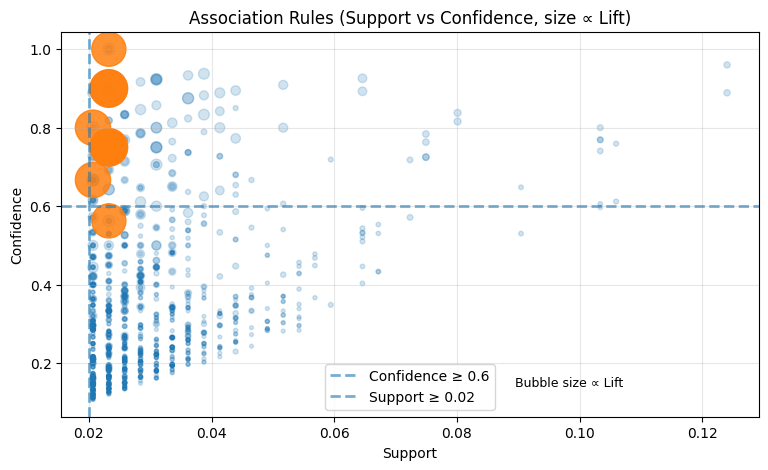

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Keep only 1 → 1 rules (easy to interpret)
rules_1to1 = rules[
    (rules["antecedents"].apply(len) == 1) &
    (rules["consequents"].apply(len) == 1)
].copy()

# Select top rules by lift (strongest associations)
top_rules = rules_1to1.sort_values("lift", ascending=False).head(10)

# (Optional teaching thresholds)
conf_thr = 0.6
supp_thr = 0.02  # adjust if you want

plt.figure(figsize=(9,5))

# All rules (background)
plt.scatter(
    rules_1to1["support"],
    rules_1to1["confidence"],
    s=np.clip(rules_1to1["lift"] * 3, 8, 80),
    alpha=0.2
)

# Strongest rules (highlighted)
plt.scatter(
    top_rules["support"],
    top_rules["confidence"],
    s=np.clip(top_rules["lift"] * 25, 120, 900),
    alpha=0.85
)

# Threshold lines (make "strong region" obvious)
plt.axhline(conf_thr, linestyle="--", linewidth=2, alpha=0.6, label=f"Confidence ≥ {conf_thr}")
plt.axvline(supp_thr, linestyle="--", linewidth=2, alpha=0.6, label=f"Support ≥ {supp_thr}")

# Small note for students
plt.text(
    0.65, 0.08, "Bubble size ∝ Lift",
    transform=plt.gca().transAxes,
    fontsize=9
)

plt.xlabel("Support")
plt.ylabel("Confidence")
plt.title("Association Rules (Support vs Confidence, size ∝ Lift)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


---
## Step 7 — Business Interpretation (Discussion)
Use these guiding questions:

- **Bundling:** which items should be bundled together?
- **Cross-selling:** if a customer buys A, what should we recommend next?
- **Layout:** which items should be placed near each other?

Rule interpretation template:

> If a customer buys **A**, they are **(lift ×)** more likely to buy **B** than a random customer.


---
## Optional Student Exercises (5–10 minutes)
1. Change `min_support` from **0.02 → 0.01**. What changes?
2. Increase rule thresholds to `confidence ≥ 0.8` and `lift ≥ 3`. What happens?
3. Compare results with and without POSTAGE (why does it dominate?).


---
## Learning Outcomes
By the end of this lab, students can:

- Explain transactional data and association rules
- Build a basket matrix from invoices
- Apply Apriori to discover frequent itemsets
- Generate and filter association rules
- Interpret results with business reasoning
- Read rule plots (support, confidence, lift)

End of Lab — Thank you!
